#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import root
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 20

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.25595454,  0.9201535 ,  0.29631877],
       [-0.03496445,  0.3151411 , -0.94840053],
       [-0.96605629,  0.23238679,  0.11283446]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.001264


In [33]:
Ret.shape

(20, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000155


In [37]:
C1(dx,dy,dz,Ret)

array([[-2.92778437e-02,  1.05475534e-01, -2.37913070e-01,
         1.76222834e-01, -2.15308488e-01, -5.38626711e-02,
        -2.30051975e-03, -6.76216526e-01, -5.38492793e-01,
        -3.99438308e-01,  1.60556997e-02, -6.52819989e-01,
        -1.42925274e-01,  4.93353110e-01,  6.16412688e-01,
        -3.42403150e+00, -8.94067851e-02, -1.35577993e+00,
         7.54785428e-02, -2.85699072e-02],
       [ 8.31267519e-01,  1.81203263e-01, -1.33211336e+00,
        -5.58871567e-01, -8.23837632e-01, -2.56092679e-01,
        -8.11744910e-01,  4.12897780e+00, -1.07230151e+00,
        -5.72316804e-01, -2.73768874e-02, -3.70834067e-01,
         7.29828601e-01,  9.78597891e-01, -3.06850134e-01,
        -9.70803239e-01, -9.47549038e-01,  2.90549007e-01,
         1.38185588e+00, -2.25991925e-01],
       [-2.50557280e+00, -4.69076232e-01, -7.54144260e-01,
        -4.54012760e-01, -3.27967142e+00, -3.03174486e-01,
        -4.08786348e-01,  2.46287616e+00, -5.94356426e-02,
        -4.20935046e-01, -1.4

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-1.68026539e+02,  4.77067251e+03, -1.43795673e+04],
       [ 6.05327672e+02,  1.03993168e+03, -2.69204441e+03],
       [-1.36539119e+03, -7.64504380e+03, -4.32805950e+03],
       [ 1.01134883e+03, -3.20738289e+03, -2.60559464e+03],
       [-1.23566272e+03, -4.72803213e+03, -1.88221456e+04],
       [-3.09119697e+02, -1.46972458e+03, -1.73992866e+03],
       [-1.32027609e+01, -4.65863159e+03, -2.34603873e+03],
       [-3.88082959e+03,  2.36963437e+04,  1.41345299e+04],
       [-3.09042841e+03, -6.15397476e+03, -3.41103170e+02],
       [-2.29239001e+03, -3.28454556e+03, -2.41576052e+03],
       [ 9.21442056e+01, -1.57116886e+02, -8.03711452e+02],
       [-3.74655607e+03, -2.12822930e+03, -2.83513903e+04],
       [-8.20253001e+02,  4.18851111e+03, -4.82618867e+03],
       [ 2.83137024e+03,  5.61620651e+03, -1.35421214e+03],
       [ 3.53761333e+03, -1.76102334e+03,  4.01095864e+01],
       [-1.96506330e+04, -5.57147274e+03,  4.47586742e+03],
       [-5.13108574e+02, -5.43801608e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000408


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000390


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000028


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 1.00775028,  0.42994838,  0.3591896 ],
       [-1.25229965, -1.4076616 ,  3.011572  ],
       [ 0.0640392 ,  0.18166839,  1.40471778],
       [-0.95454898, -0.1545585 , -0.71210859],
       [-0.6862688 ,  1.61238601, -1.58263975],
       [-0.59069351, -0.73701189,  0.31205693],
       [ 0.45883627, -2.91304419,  0.71391709],
       [ 0.08854321, -0.37313094, -1.83131501],
       [-0.91120529, -0.39210083,  0.59350233],
       [ 1.0635721 , -0.21304916,  1.22748282],
       [ 1.41593856,  0.95124513,  0.38487626],
       [-0.8532585 ,  0.40985659, -0.04798298],
       [ 0.61095475, -0.05910231, -0.83146842],
       [ 1.91809902, -0.92841409,  1.87266027],
       [ 1.19312678,  0.90368058, -1.42037046],
       [ 0.49989231, -0.72827398, -0.0794847 ],
       [-0.03355951,  1.46965789,  3.39255357],
       [ 0.98921223, -0.95243848,  0.30012933],
       [ 1.55432347,  0.18658841,  0.28425219],
       [ 0.5976929 ,  1.35165137,  1.68301512]])

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000162


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000514


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000543


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.71853078, -0.85912935,  0.754114  ],
       [ 0.41142628,  1.31175652, -1.17891531],
       [ 0.11275844, -0.64370193,  0.4614746 ],
       [ 0.17682288,  1.39211074, -0.66486309],
       [-1.30833144,  1.14885738, -1.09302302],
       [ 1.00769407, -1.91028439, -2.28939295],
       [-0.24403453,  2.00874707, -1.03682596],
       [ 1.22784352,  4.75952304, -0.58287202],
       [-0.61440892,  0.58947579,  0.32063907],
       [-0.01807047, -1.54086771,  0.70496387],
       [ 0.74063607,  0.60739679, -0.76721043],
       [ 0.04993158, -1.97173882,  1.18487855],
       [ 1.63470198, -1.64268599,  0.7031166 ],
       [ 1.11169424, -0.03851377,  1.12009334],
       [ 0.84042997, -1.33826144, -1.70600863],
       [-0.36769107, -0.14697327, -1.15495839],
       [ 2.71978065,  0.546933  ,  1.58555337],
       [-0.36171682,  0.26762599,  0.66432142],
       [ 1.16101947, -1.05571494,  0.54636528],
       [-0.91824085,  0.06869874,  0.54385171]])

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-0.00061454,  0.03970712,  0.01101895, -0.00502693, -0.02867654,
         0.00940496,  0.03249691, -0.01314553,  0.00885164,  0.01295609,
        -0.0050487 , -0.00409996, -0.00695566,  0.02516596, -0.02087324,
         0.00580224,  0.01738584,  0.01122557,  0.00088886,  0.00305325],
       [-0.02693398, -0.31264932, -0.1400314 ,  0.06273536,  0.15227173,
        -0.03652163, -0.06735279,  0.18409698, -0.06756121, -0.11334577,
        -0.02585197, -0.00283346,  0.08869319, -0.17027685,  0.15284923,
         0.0124298 , -0.33987629, -0.02118828, -0.01454157, -0.16311147],
       [ 0.03396404, -0.1296264 ,  0.01760755, -0.00687792,  0.16756853,
        -0.06845361, -0.29570999, -0.03814539, -0.03104477, -0.03089897,
         0.0824686 ,  0.04870514, -0.01141543, -0.11019523,  0.07971333,
        -0.07739608,  0.14740676, -0.10423841,  0.00468497,  0.12991264]])

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000665


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[ 5.53194355e-07,  1.60273897e-06,  1.86890111e-07,
        -8.83723008e-08, -1.71202954e-06, -1.14690208e-06,
        -5.99143152e-07,  9.42025505e-07,  4.78106979e-07,
         2.18568093e-08, -1.46516864e-06, -8.44987154e-07,
        -1.57010697e-07,  2.81958737e-06,  2.34834833e-06,
         4.11836747e-07,  5.62749427e-06,  2.62291059e-07,
         1.80192959e-06, -1.04866283e-06],
       [-9.17638665e-03,  8.27817694e-03, -6.93096792e-03,
        -7.43806352e-03,  1.62591475e-02,  2.32346529e-03,
         1.60425836e-02,  4.33234052e-03, -1.06809510e-02,
         1.60130793e-04,  1.01731926e-02,  9.36203911e-03,
        -6.09981014e-03, -1.78841668e-02, -8.26886703e-03,
         2.33660474e-03, -3.04131688e-02, -1.11604429e-04,
        -1.19783108e-02, -1.09313486e-02],
       [ 3.58874767e-03, -2.44686966e-02,  5.04344490e-03,
         8.33113503e-03,  1.03412963e-03,  9.26187160e-03,
        -9.99113988e-03, -1.38484498e-02,  5.85188495e-03,
        -3.80925910e-04,  4.6

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.68026539e+02, -6.05327672e+02,  1.36539119e+03,
        -1.01134883e+03,  1.23566272e+03,  3.09119697e+02,
         1.32027609e+01,  3.88082959e+03,  3.09042841e+03,
         2.29239001e+03, -9.21442056e+01,  3.74655607e+03,
         8.20253001e+02, -2.83137024e+03, -3.53761333e+03,
         1.96506330e+04,  5.13108574e+02,  7.78086706e+03,
        -4.33173918e+02,  1.63963667e+02],
       [-4.77067251e+03, -1.03993168e+03,  7.64504380e+03,
         3.20738289e+03,  4.72803213e+03,  1.46972458e+03,
         4.65863159e+03, -2.36963437e+04,  6.15397476e+03,
         3.28454556e+03,  1.57116886e+02,  2.12822930e+03,
        -4.18851111e+03, -5.61620651e+03,  1.76102334e+03,
         5.57147274e+03,  5.43801608e+03, -1.66747061e+03,
        -7.93051777e+03,  1.29697533e+03],
       [ 1.42514028e+04,  2.56387987e+03,  4.19989496e+03,
         2.47743009e+03,  1.86939810e+04,  1.61176412e+03,
         2.21787418e+03, -1.42626944e+04,  2.12938628e+02,
         2.28759597e+03,  6.7

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000827


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.08112639e+02,  2.97563006e+06, -8.73526810e+05],
       [ 1.15224685e+01, -1.21219140e+05,  4.83083308e+03],
       [-1.05276252e+02,  3.79538840e+06, -2.73213054e+06],
       [ 7.16546709e+01, -3.73686287e+04, -6.86450589e+05],
       [-2.94241564e+01,  9.99442585e+04,  1.97279389e+05],
       [-7.70134318e+00, -2.05015906e+06,  2.12805823e+06],
       [-5.21684829e+01, -7.90017905e+03,  5.34881567e+05],
       [-1.10363801e+02,  1.12710624e+06, -1.23211814e+04],
       [ 9.45945323e+01, -1.87609804e+06,  9.20644527e+05],
       [ 5.44020257e+01,  7.05485614e+04, -6.20095302e+05],
       [ 7.87220909e+01, -1.20137011e+05, -6.75069698e+05],
       [ 9.09276084e+00,  1.65559856e+05, -2.57418953e+05],
       [-2.83982811e+01,  2.74489840e+05,  1.23620627e+04],
       [-5.89726395e-04, -9.74925597e+02,  9.80932135e+02],
       [-1.25759355e+02, -1.11692824e+04,  1.28153052e+06],
       [-2.60091238e+02,  1.60620465e+06,  1.02103087e+06],
       [-2.35701766e+02,  2.36880772e+06

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-1.18258372e+08, -8.73643886e+07, -2.97574713e+08],
       [-1.67679922e+07,  4.81423277e+05,  1.21202540e+07],
       [-4.23555267e+08, -2.73254986e+08, -3.79580770e+08],
       [-5.53416111e+06, -6.86456068e+07,  3.73631502e+06],
       [ 5.68375294e+06,  1.97285016e+07, -9.99386319e+06],
       [ 6.38520862e+08,  2.12869037e+08,  2.05079117e+08],
       [ 7.36841859e+07,  5.34954514e+07,  7.97312271e+05],
       [-3.88941204e+06, -1.23250319e+06, -1.12711009e+08],
       [-5.52826807e+08,  9.20097229e+07,  1.87555077e+08],
       [-2.57909527e+04, -6.20095328e+07, -7.05485869e+06],
       [-4.44214709e+08, -6.75509471e+07,  1.19697261e+07],
       [ 6.15783252e+07, -2.57357991e+07, -1.65498896e+07],
       [ 6.04958332e+05,  1.23626616e+06, -2.74489241e+07],
       [-9.97737946e+08, -6.82859763e+02, -1.27850829e+03],
       [ 1.38884885e+08,  1.28166802e+08,  1.13067715e+06],
       [-4.86481568e+07,  1.02098271e+08, -1.60625281e+08],
       [ 1.62848876e+08,  1.21796283e+06

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000268


In [76]:
Re_b(Ret).shape

(20, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.000416


In [82]:
d_me_

array([[ 2.68143432e-02, -1.92796898e+02, -7.80589632e+01],
       [-8.48550414e-03,  5.22506594e+01,  3.34631849e+01],
       [-1.11834649e-02, -1.04056485e+02,  2.17031756e+02],
       [-5.77045933e-02,  2.71790892e+01,  5.55723653e+02],
       [ 3.12220580e-02, -3.03400805e+02, -1.19740721e+01],
       [-1.54021501e-02,  2.15180041e+02, -5.96058138e+01],
       [-1.85735476e-02,  1.73042238e+02,  1.45700615e+01],
       [ 1.15065081e-02, -9.55052019e+01, -2.07231836e+01],
       [-2.34728879e-02,  3.25235103e+02, -8.81397313e+01],
       [-5.58748875e-02, -6.13969994e+00,  5.70561320e+02],
       [-1.21944380e-02,  5.51426524e+02, -4.28272105e+02],
       [-6.37945259e-03,  1.35369711e+02, -7.09344011e+01],
       [ 2.08250312e-03, -2.06068524e+01, -4.28550865e-01],
       [-2.01807813e-07,  9.88431898e+02, -9.88479949e+02],
       [ 4.05306155e-02, -2.89806774e+02, -1.19599374e+02],
       [ 8.08951577e-02, -7.95396129e+02, -2.17276393e+01],
       [-6.76798780e-02,  1.00543782e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 1.68026539e+02, -6.05327672e+02,  1.36539119e+03,
        -1.01134883e+03,  1.23566272e+03,  3.09119697e+02,
         1.32027609e+01,  3.88082959e+03,  3.09042841e+03,
         2.29239001e+03, -9.21442056e+01,  3.74655607e+03,
         8.20253001e+02, -2.83137024e+03, -3.53761333e+03,
         1.96506330e+04,  5.13108574e+02,  7.78086706e+03,
        -4.33173918e+02,  1.63963667e+02],
       [-4.77067251e+03, -1.03993168e+03,  7.64504380e+03,
         3.20738289e+03,  4.72803213e+03,  1.46972458e+03,
         4.65863159e+03, -2.36963437e+04,  6.15397476e+03,
         3.28454556e+03,  1.57116886e+02,  2.12822930e+03,
        -4.18851111e+03, -5.61620651e+03,  1.76102334e+03,
         5.57147274e+03,  5.43801608e+03, -1.66747061e+03,
        -7.93051777e+03,  1.29697533e+03],
       [ 1.42514028e+04,  2.56387987e+03,  4.19989496e+03,
         2.47743009e+03,  1.86939810e+04,  1.61176412e+03,
         2.21787418e+03, -1.42626944e+04,  2.12938628e+02,
         2.28759597e+03,  6.7

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617, 3150635.90893617])

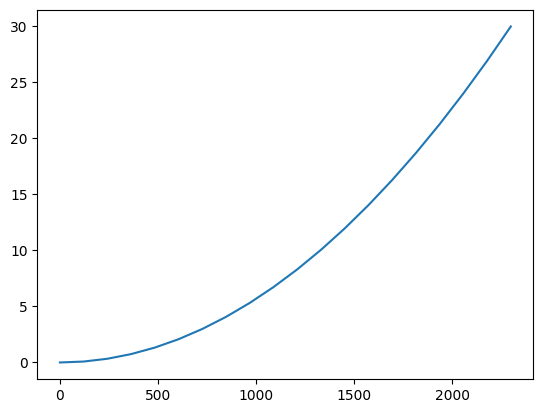

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0*9.81,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root_ = root(static_func, q0)

In [103]:
root_

 message: The iteration is not making good progress, as measured by the 
            improvement from the last ten iterations.
 success: False
  status: 5
     fun: [ 0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00]
       x: [ 0.000e+00  1.210e+02 ...  0.000e+00  0.000e+00]
  method: hybr
    nfev: 491
    fjac: [[ 0.000e+00  0.000e+00 ... -4.199e-17 -3.987e-17]
           [ 0.000e+00  0.000e+00 ...  1.091e-16  1.036e-16]
           ...
           [ 0.000e+00  0.000e+00 ...  3.547e-11 -3.736e-11]
           [ 0.000e+00  0.000e+00 ... -1.366e-13  1.012e-13]]
       r: [-4.698e+02 -4.698e+02 ...  0.000e+00 -0.000e+00]
     qtf: [-1.066e-01 -1.486e+00 ...  0.000e+00  0.000e+00]

In [104]:
x0_,z0_=root_.x[:node_N],root_.x[4*node_N:5*node_N]

In [105]:
q0=root_.x

In [106]:
q0

array([0.00000000e+00, 1.20965559e+02, 2.41931119e+02, 3.62896678e+02,
       4.83862238e+02, 6.04827797e+02, 7.25793357e+02, 8.46758916e+02,
       9.67724476e+02, 1.08869004e+03, 1.20965559e+03, 1.33062115e+03,
       1.45158671e+03, 1.57255227e+03, 1.69351783e+03, 1.81448339e+03,
       1.93544895e+03, 2.05641451e+03, 2.17738007e+03, 2.29834563e+03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

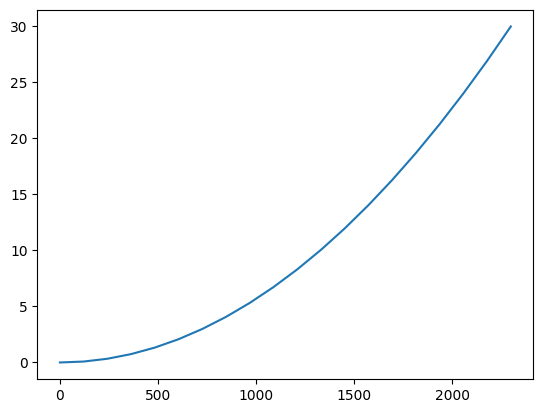

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))

    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])
#     print(K)  

      


    tmp = root(lambda x: x - K@np.array(vessel_movement), np.zeros(len(vessel_movement)))
#     print(tmp.success)
    glob_force=tmp.x
#     print(np.isclose(np.linalg.pinv(K)@glob_force - np.array(vessel_movement), np.zeros(len(vessel_movement)) ))
    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6)

    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]

#     f=ku 
    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)
    

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [1, 2],
                      [2, 3]]),
        bc_node=list(range(6)),
        bc_val=[0]*6,
        vessel_movement=[
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                        -0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4],
        coefs=[1,1,1,1,1,1])

In [113]:
-0.0705e-4, -0.0007e-4, 0.1418e-4

(-7.05e-06, -7e-08, 1.418e-05)

In [114]:
# f=k*d
# k^-1*f=d

In [115]:
d

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -3.44304000e-08,  6.05718317e-04,
       -9.47786515e-04, -1.23428564e-02,  9.41881267e-04,  6.08703365e-04,
       -5.46459404e-03, -4.17238913e-02,  4.52110880e-03, -1.32885436e-02,
        2.25929495e-03,  1.40011664e-03,  6.90670736e-03, -1.85833039e-03,
        5.76894634e-02, -1.32870936e-02,  2.26104495e-03,  1.40125664e-03])

In [116]:
f

array([ 4.82025600e+01,  5.73695230e+03, -4.34033027e+03,  1.72799990e+04,
       -8.26734720e+01,  8.35813440e+01,  3.41281065e-09,  3.18314394e-09,
       -1.02840068e-09,  1.60779105e-10,  5.26560594e-11, -3.54849913e-10,
        3.92537913e-09, -1.11758709e-08,  9.31322575e-09, -2.03726813e-10,
        1.52795110e-10, -3.63797881e-11, -4.82025600e+01, -5.73695230e+03,
        4.34033027e+03,  8.13220800e+01,  8.26734720e+01,  1.09228896e+02])

In [117]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9,  
#               A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
              A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for i in range(1,len(X)):
        elcon.append([i-1,i])

    bc_node=list(range(6))
    bc_val=[0]*6

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [118]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [119]:
fors

array([[-3.73324401e+05,  5.06090921e+02, -9.06051299e+03],
       [-1.78217888e-04,  3.42922576e-05,  8.78283754e-06],
       [ 1.02043152e-04, -8.99444422e-05, -1.84252858e-05],
       [-1.69038773e-04,  5.49234245e-05, -3.59592959e-05],
       [-2.51770020e-04, -7.81526323e-05, -6.76512718e-06],
       [-5.34057617e-05,  2.98200175e-05,  3.43322754e-05],
       [ 2.89916992e-04, -3.01133841e-05,  1.02519989e-05],
       [-2.28881836e-05,  3.15969765e-05, -1.05500221e-05],
       [ 1.29699707e-04,  4.62881289e-05,  7.62939453e-06],
       [ 1.52587891e-04, -5.17135486e-05,  1.62124634e-05],
       [ 1.22070312e-04,  7.47330487e-05,  6.19888306e-06],
       [-7.62939453e-04, -5.12053821e-05, -2.40802765e-05],
       [ 4.57763672e-05,  5.92861325e-05, -2.38418579e-06],
       [ 9.76562500e-04, -6.18062913e-05,  3.05175781e-05],
       [-6.10351562e-04,  5.58402389e-05, -1.33514404e-05],
       [-4.51728090e-04, -4.82370781e-05, -2.58921471e-05],
       [ 8.72981589e-04,  3.84236009e-05

### Vessle Simulation

In [120]:
sampleTime = 0.001              # sample time [seconds]
N = 30000                      # number of samples

In [121]:
N*sampleTime

30.0

In [122]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [123]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [124]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

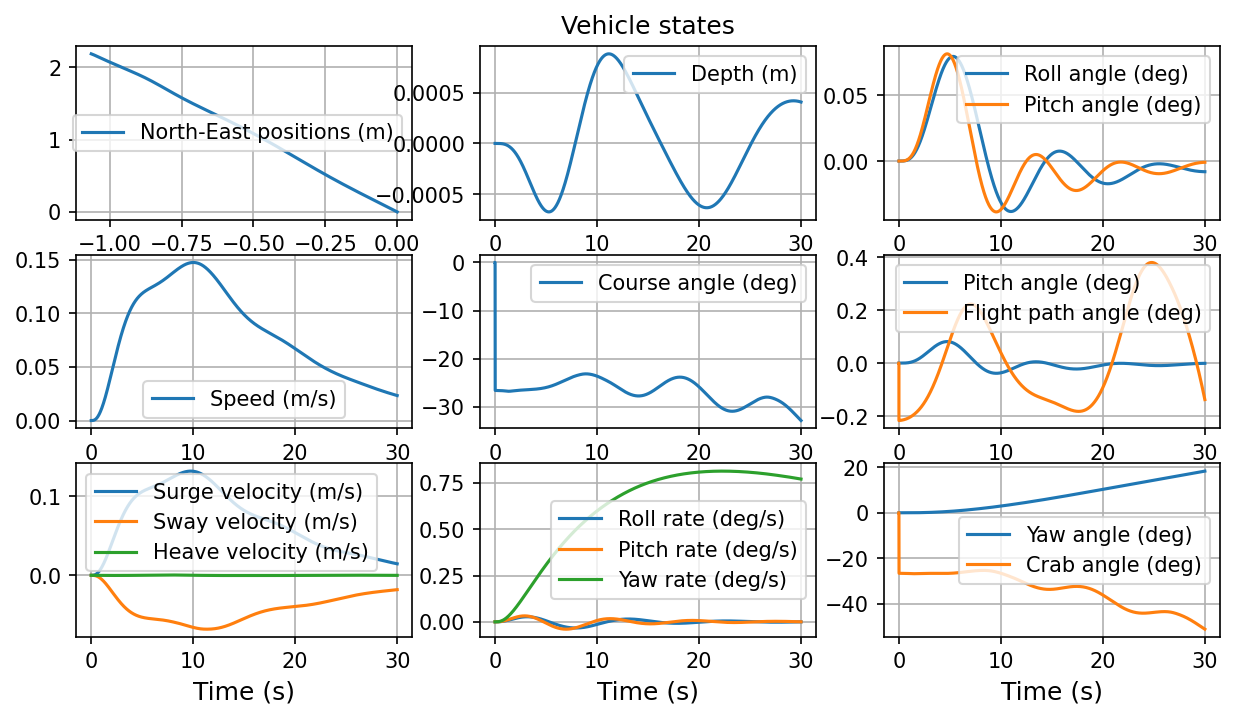

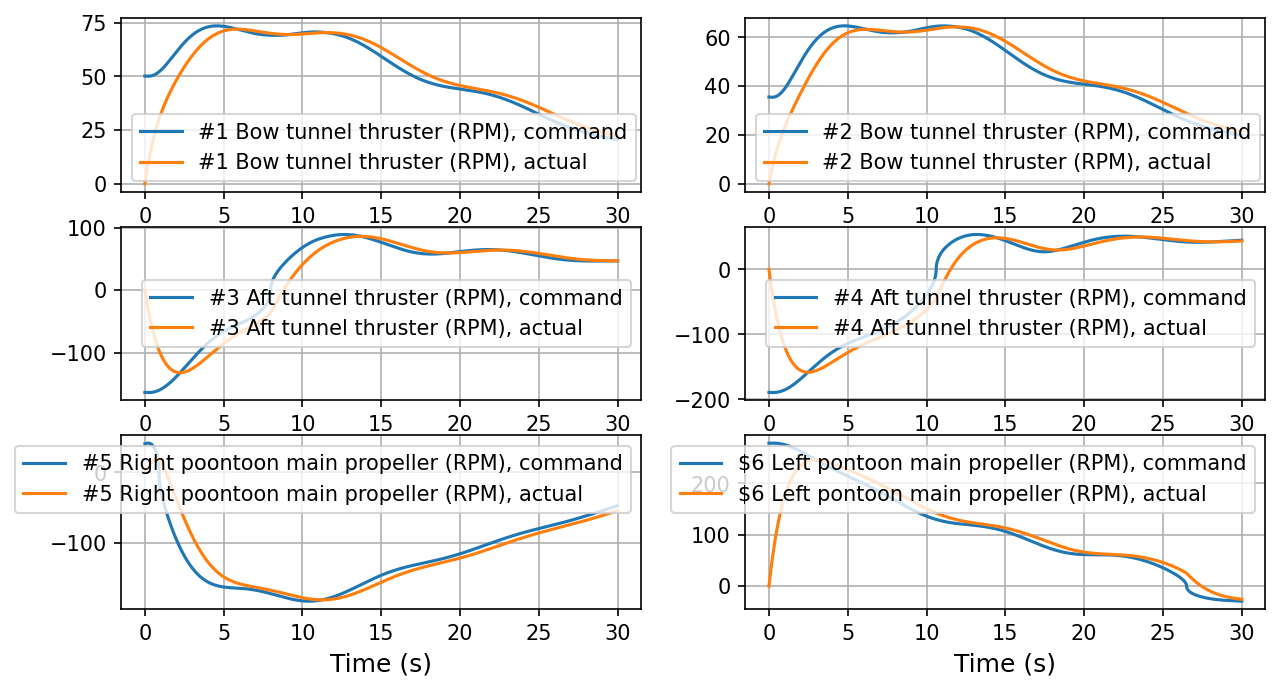

In [125]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [126]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

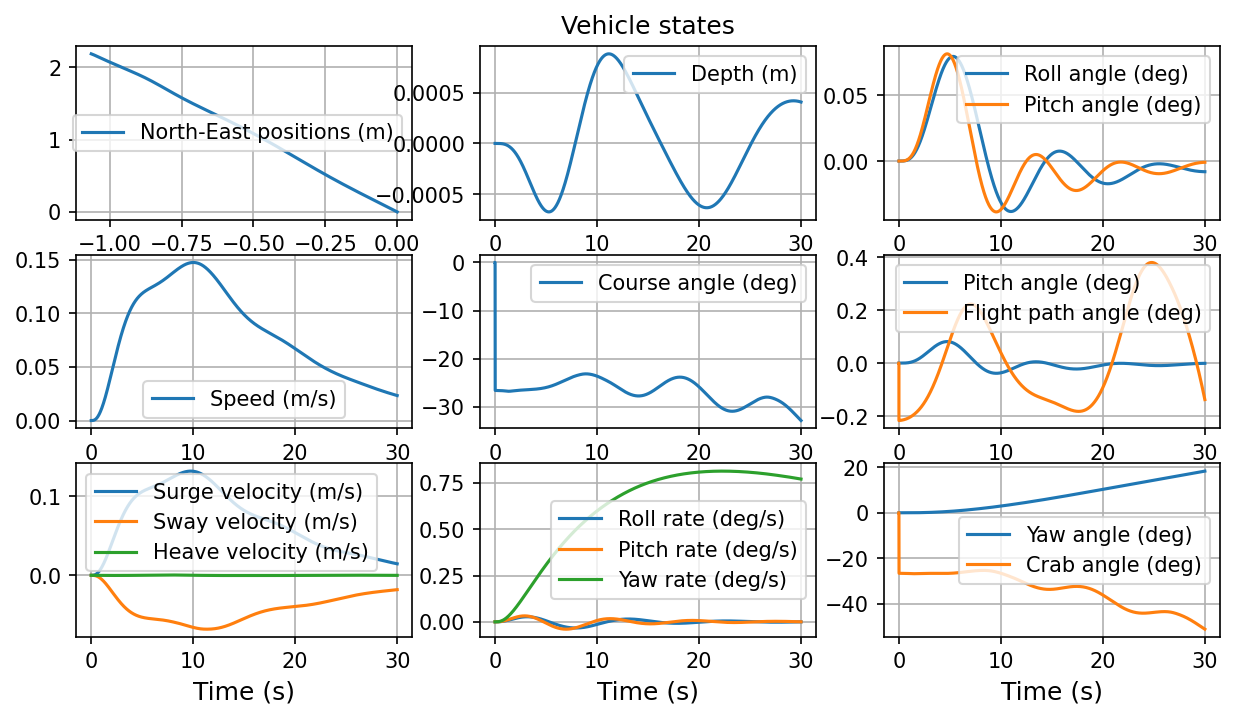

In [127]:
plotVehicleStates(simTime, simData, 3)

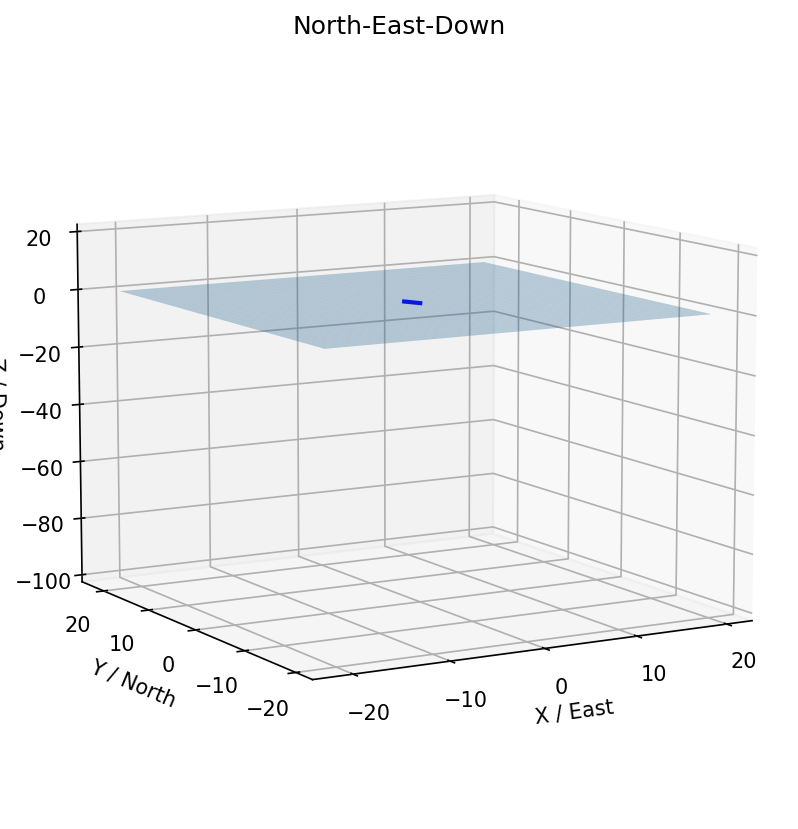

In [128]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [129]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [130]:
idx=1/0.01

In [131]:
idx

100.0

In [132]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [133]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [134]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [135]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [136]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [137]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(250)]
        self.wall_clock = datetime.now()

In [138]:
def grayscott1d(t, Q, coefs, T):
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]


#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])

#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])


#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]


#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]

#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve - T.v_m[0]
    vessel_movement[1] = y_ve - T.v_m[1]
    vessel_movement[2] = -z_ve  - T.v_m[2]
    vessel_movement[3] = phi_ve - T.v_m[3]
    vessel_movement[4] = theta_ve  - T.v_m[4]
    vessel_movement[5] = psi_v- T.v_m[5]

    T.v_m[0] = x_ve
    T.v_m[1] = y_ve
    T.v_m[2] = -z_ve
    T.v_m[3] = phi_ve
    T.v_m[4] = theta_ve
    T.v_m[5] = psi_v


    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)

    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
#         print(T.progression)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

#     T.v_m=np.copy(vessel_movement)

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [142]:
tspan = (0., 15)
T_ = MyTime()

In [143]:
coefs = [1e-6, 
         1e-6, 
         1e-6, 
         1e-6, 
         1e-6, 
         1e-6]

In [144]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
             
#             method='LSODA',
#              t_eval=[i*sampleTime for i in range(int(tspan[-1]/(sampleTime)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.3396406397295392  Iteration wall clock time:  0:00:01.482536
Physical time:  1.0124983033992556  Iteration wall clock time:  0:00:46.218818
Physical time:  2.010626508066805  Iteration wall clock time:  0:01:14.849021
Physical time:  3.010450651686993  Iteration wall clock time:  0:01:21.885720
Physical time:  4.017198013890608  Iteration wall clock time:  0:01:18.399899
Physical time:  5.022699694020028  Iteration wall clock time:  0:01:12.258903
Physical time:  6.002350688042828  Iteration wall clock time:  0:01:02.816350
Physical time:  7.004961850935632  Iteration wall clock time:  0:00:59.746698
Physical time:  8.006312962080637  Iteration wall clock time:  0:00:57.611649
Physical time:  9.004882666169356  Iteration wall clock time:  0:00:54.958789
Physical time:  10.002404529722819  Iteration wall clock time:  0:00:53.983884
Physical time:  11.000353296743988  Iteration wall clock time:  0:00:54.834080
Physical time:  12.00546745954442  Iteration wall clock time

### Results

In [145]:
fin=us

In [146]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.197e-01 ...  1.494e+01  1.500e+01]
        y: [[ 0.000e+00  7.109e-15 ...  1.859e-06  1.879e-06]
            [ 1.210e+02  1.210e+02 ...  1.210e+02  1.210e+02]
            ...
            [ 0.000e+00 -3.828e-11 ... -1.281e-05 -1.272e-05]
            [ 0.000e+00 -4.038e-11 ... -1.351e-05 -1.342e-05]]
      sol: None
 t_events: None
 y_events: None
     nfev: 1646
     njev: 0
      nlu: 0

In [147]:
t=fin.t

In [148]:
fin=fin.y.T

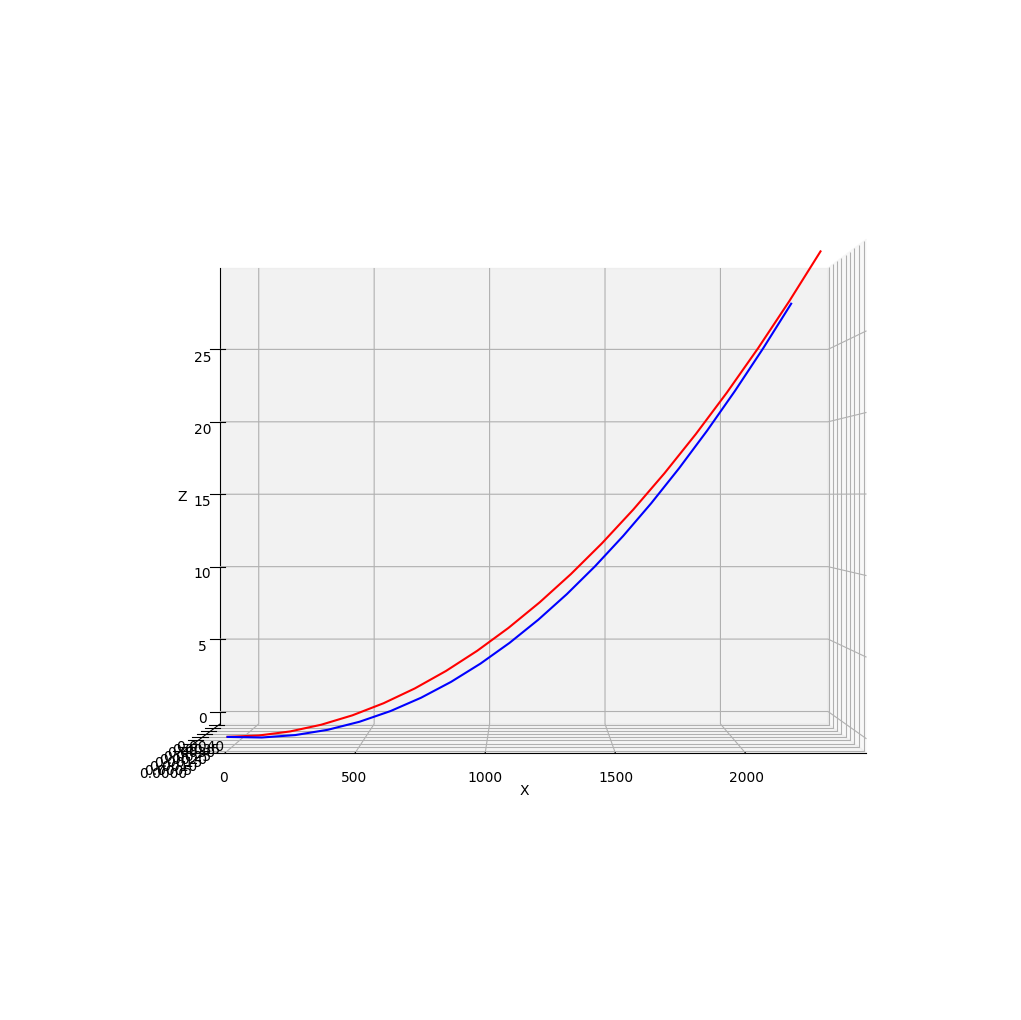

In [173]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
# ax.view_init(-45,-45)
# ax.view_init(-30,-30)
ax.view_init(0,-90)
plt.show()

In [150]:
X,Y,Z

(array([1.87884679e-06, 1.20965013e+02, 2.41927194e+02, 3.62884837e+02,
        4.83837207e+02, 6.04784292e+02, 7.25726579e+02, 8.46664879e+02,
        9.67600178e+02, 1.08853352e+03, 1.20946590e+03, 1.33039824e+03,
        1.45133126e+03, 1.57226555e+03, 1.69320144e+03, 1.81413909e+03,
        1.93507845e+03, 2.05601924e+03, 2.17696102e+03, 2.29790316e+03]),
 array([-6.70220879e-11,  4.19747834e-04,  8.15324053e-04,  1.18644333e-03,
         1.53300641e-03,  1.85505000e-03,  2.15270433e-03,  2.42615788e-03,
         2.67562851e-03,  2.90134052e-03,  3.10350686e-03,  3.28231596e-03,
         3.43792259e-03,  3.57044214e-03,  3.67994768e-03,  3.76646942e-03,
         3.82999574e-03,  3.87047550e-03,  3.88782091e-03,  3.88191058e-03]),
 array([-4.55047706e-03, -2.16293061e-01, -2.29963932e-01, -4.74301764e-02,
         3.29445142e-01,  8.98805197e-01,  1.65880070e+00,  2.60759041e+00,
         3.74334106e+00,  5.06422686e+00,  6.56842861e+00,  8.25413270e+00,
         1.01195299e+01,  1.

In [151]:
X0,Y0,Z0

(array([   0.        ,  120.9655595 ,  241.93111899,  362.89667849,
         483.86223798,  604.82779748,  725.79335697,  846.75891647,
         967.72447596, 1088.69003546, 1209.65559495, 1330.62115445,
        1451.58671394, 1572.55227344, 1693.51783294, 1814.48339243,
        1935.44895193, 2056.41451142, 2177.38007092, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([ 0.        ,  0.08306948,  0.33227809,  0.74762628,  1.32911485,
         2.0767449 ,  2.99051782,  4.07043536,  5.31649953,  6.7287127 ,
         8.30707753, 10.05159699, 11.96227438, 14.0391133 , 16.28211766,
        18.69129171, 21.26663997, 24.00816732, 26.91587892, 29.98978026]))

In [152]:
us=fin.T

In [153]:
us.shape

(240, 270)

In [154]:
12*50

600

In [155]:
us.T[:,4*node_N+49]

array([ 0.00000000e+00,  5.25194950e-16,  5.14801633e-14,  2.02575183e-13,
        3.57748682e-13,  5.04540531e-13,  6.45529697e-13,  7.62518860e-13,
        8.60500120e-13,  9.41930825e-13,  1.00930050e-12,  1.06584443e-12,
        1.11166861e-12,  1.14802944e-12,  1.17560879e-12,  1.19404730e-12,
        1.20301014e-12,  1.20298162e-12,  1.19388935e-12,  1.17509692e-12,
        1.14599060e-12,  1.10623288e-12,  1.05510379e-12,  9.91182438e-13,
        9.13758146e-13,  8.22037347e-13,  7.14987267e-13,  5.89815903e-13,
        4.45961525e-13,  2.86014900e-13,  1.03393426e-13, -9.89280542e-14,
       -3.22518552e-13, -5.77822060e-13, -8.57457980e-13, -1.16690765e-12,
       -1.51661674e-12, -1.89631463e-12, -2.31348878e-12, -2.77069243e-12,
       -3.28320586e-12, -3.83506800e-12, -4.45097640e-12, -5.11152281e-12,
       -5.84603917e-12, -6.64153799e-12, -7.49139690e-12, -8.43334832e-12,
       -9.42825972e-12, -1.05154072e-11, -1.17018728e-11, -1.29933796e-11,
       -1.43960517e-11, -

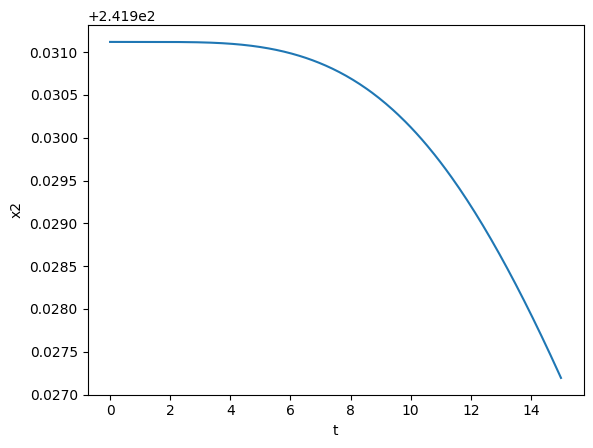

In [156]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

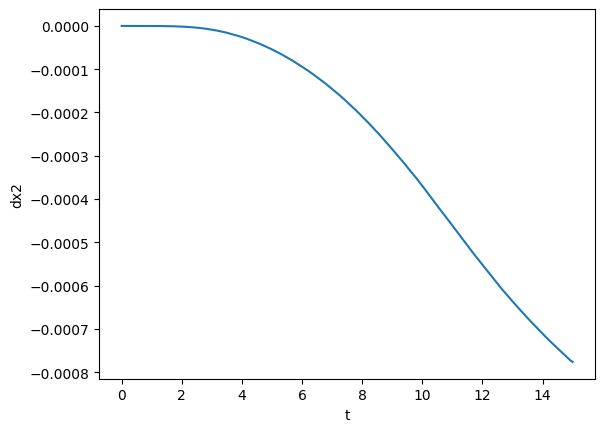

In [157]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

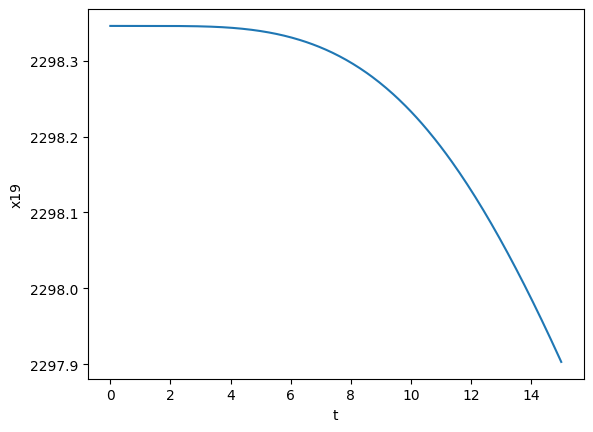

In [158]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x19')
plt.show()

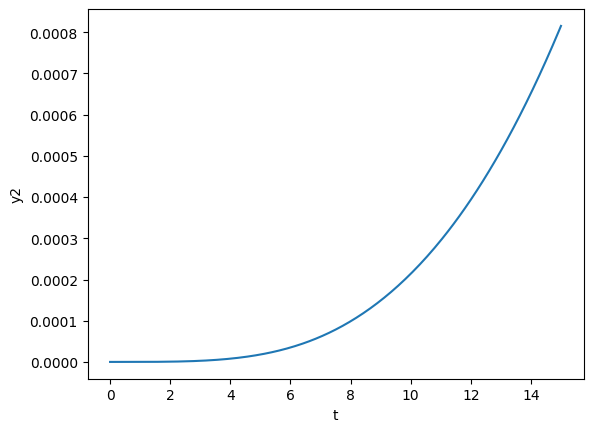

In [159]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

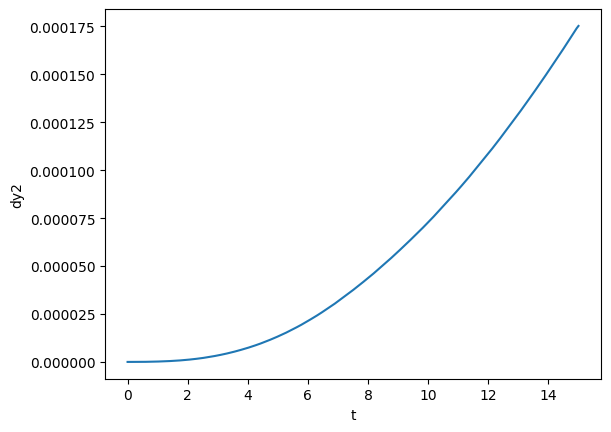

In [160]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

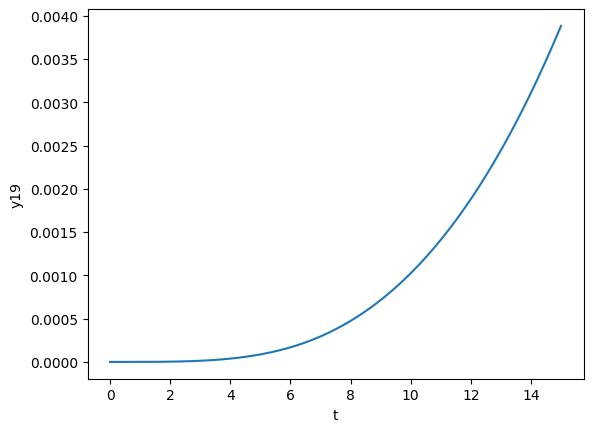

In [161]:
plt.plot(t,us.T[:,2*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('y19')
plt.show()

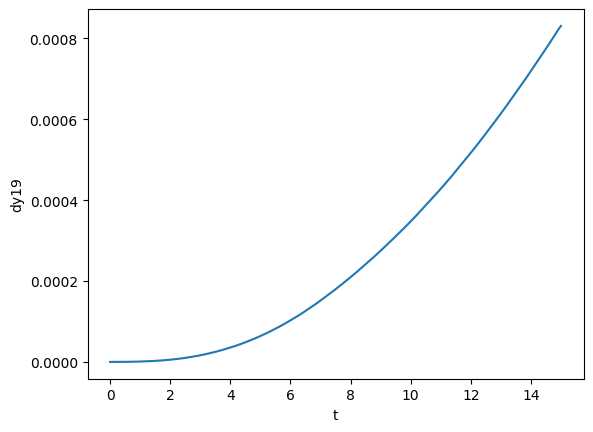

In [162]:
plt.plot(t,us.T[:,3*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('dy19')
plt.show()

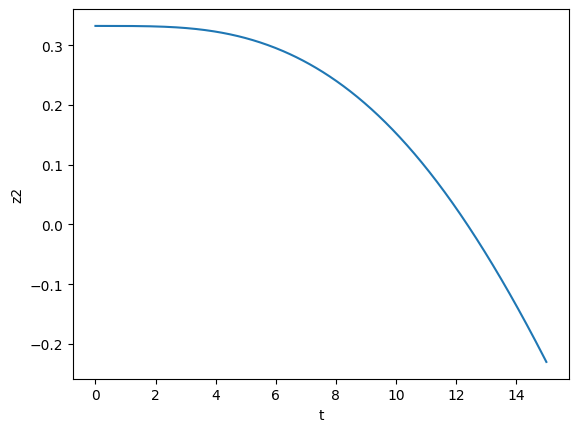

In [163]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

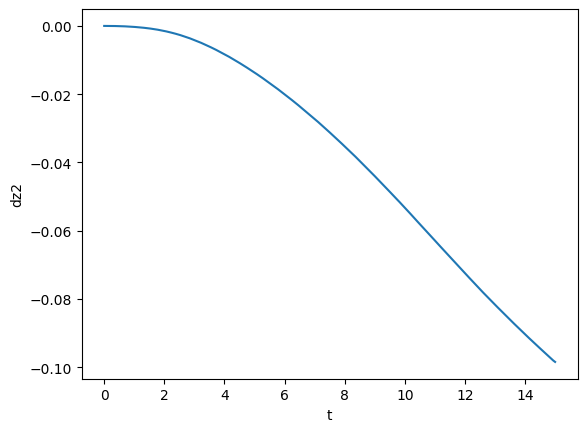

In [164]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

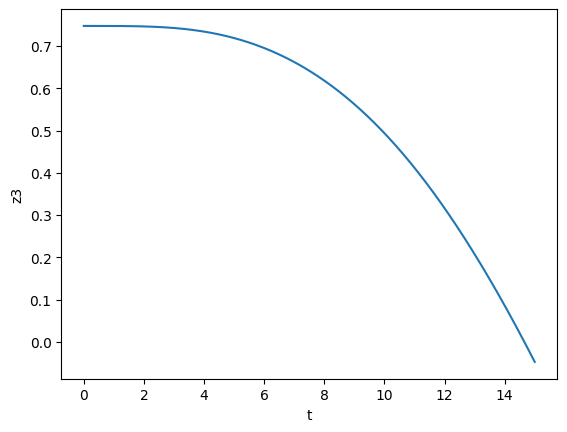

In [165]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

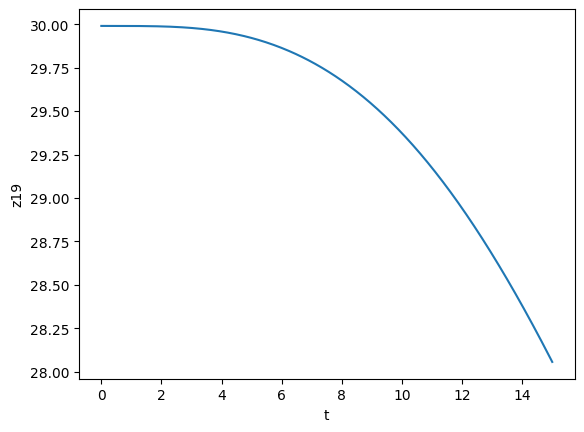

In [166]:
plt.plot(t,us.T[:,4*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('z19')
plt.show()

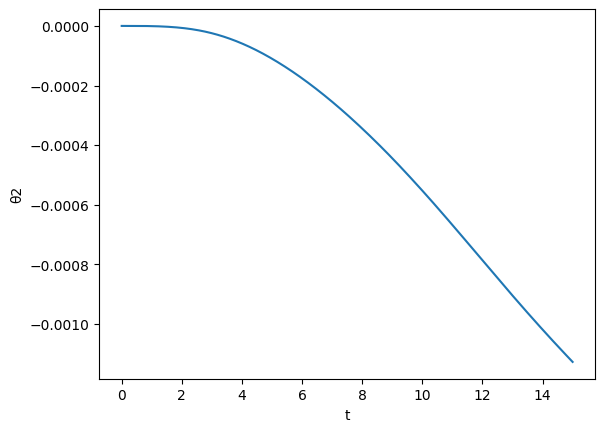

In [167]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

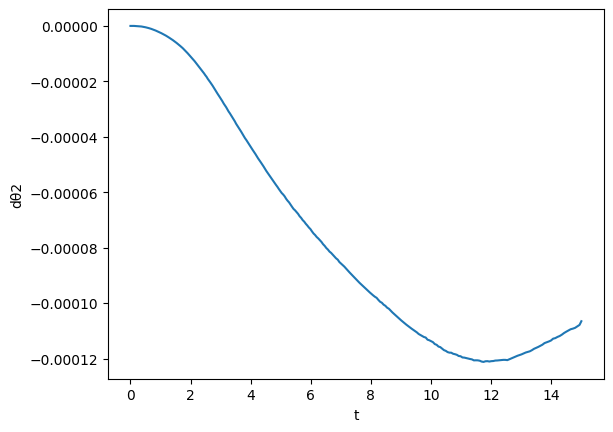

In [168]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

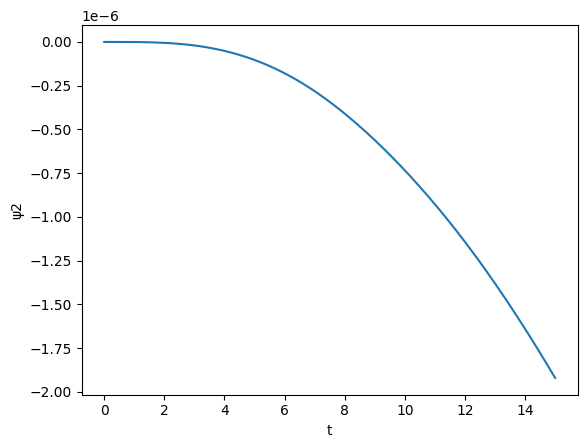

In [169]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

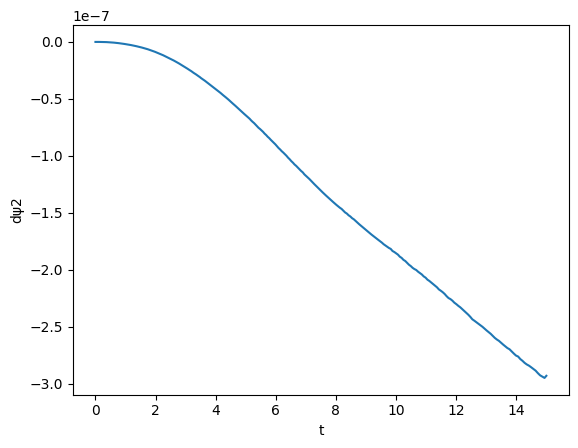

In [170]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()

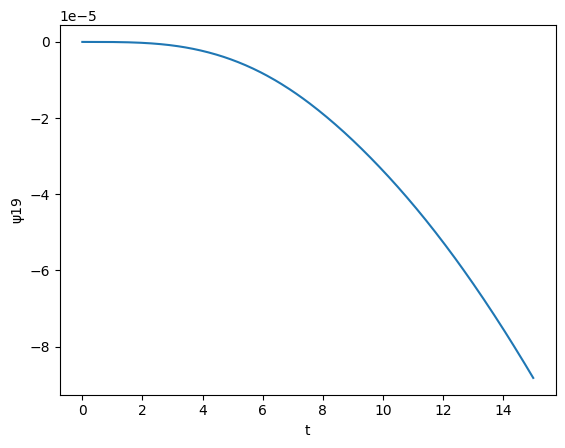

In [171]:
plt.plot(t,us.T[:,10*node_N+19] ,'-')
plt.xlabel('t')
plt.ylabel('ψ19')
plt.show()